This notebook demonstrates the use of the CausalML implemented DR Learner by Kennedy (2020) (https://arxiv.org/abs/2004.14497) for the Individual Treatment Effect (ITE) estimation.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


# Synthetic Data Generation

In [4]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

# Comparing DR Learner with X Learner

We use a flexible ML estimator to estimate the outcome model but a simple linear regression model to estimate the ITE, since the ITE estimate is often noisy and prone to overfit with a flexible estimator.

In [5]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

In [6]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

DR Learner outforms X Learner in this dataset. Even with built-in mechanism to counteract the unbalancedness between the treatment and control samples, X Learner still suffers from the regime where the treatment probability is close to 1 in this case.

Text(0.5, 1.0, 'DR Learner')

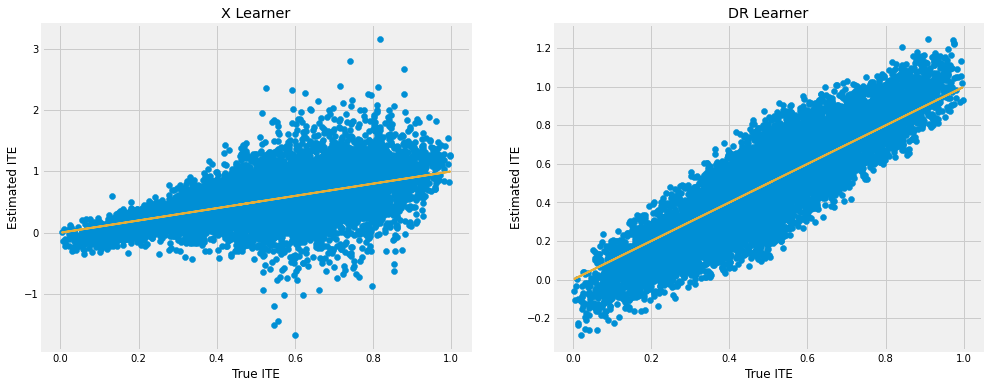

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Synthetic Data with Hidden Confounder

Now we tweaked the previous synthetic data generation by the following 2 changes
- Adding a random assignment mechanism. Only assigned units may potentially have a treatment, though whether a unit gets treatment in the assigned group depends on its confounding variables. Therefore this is a situation of one-sided non-compliance.
- One of the confounding variables that affects both the propensity to receive treatment and the treatment effect is not observed by analyst. Therefore it is a problem of hidden confounder.

In [8]:
n = 10000
p = 8
sigma = 1.0

X = np.random.uniform(size=n*p).reshape((n, -1))
b = np.sin(np.pi * X[:, 0] * X[:, 1]) + 2 * (X[:, 2] - 0.5) ** 2 + X[:, 3] + 0.5 * X[:, 4]
assignment = (np.random.uniform(size=10000)>0.5).astype(int)
eta = 0.1
e = np.maximum(np.repeat(eta, n), np.minimum(np.sin(np.pi * X[:, 0] * X[:, 1]), np.repeat(1-eta, n)))
e[assignment == 0] = 0
tau = (X[:, 0] + X[:, 1]) / 2
X_obs = X[:, [i for i in range(8) if i!=1]]

w = np.random.binomial(1, e, size=n)
treatment = w
y = b + (w - 0.5) * tau + sigma * np.random.normal(size=n)

# Comparing X Learner, DR Learner, and DRIV Learner

We use 3 learners, X Learner, DR Learner, and DRIV Learner, to estimate the ITE of the compliers, i.e. those who only receive treatment when they are assigned. 

In [9]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X_obs, treatment=treatment, y=y)

In [10]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X_obs, treatment=treatment, y=y)

In [12]:
learner_driv = BaseDRIVRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_driv = learner_driv.fit_predict(X=X_obs, assignment=assignment, treatment=treatment, y=y)

We continue to see that X Learner generates a noisier ITE estimate than DR Learner, though both of them have a upward bias. But DRIV Learner is able to alleviate the bias significantly.

Text(0.5, 1.0, 'DRIV Learner')

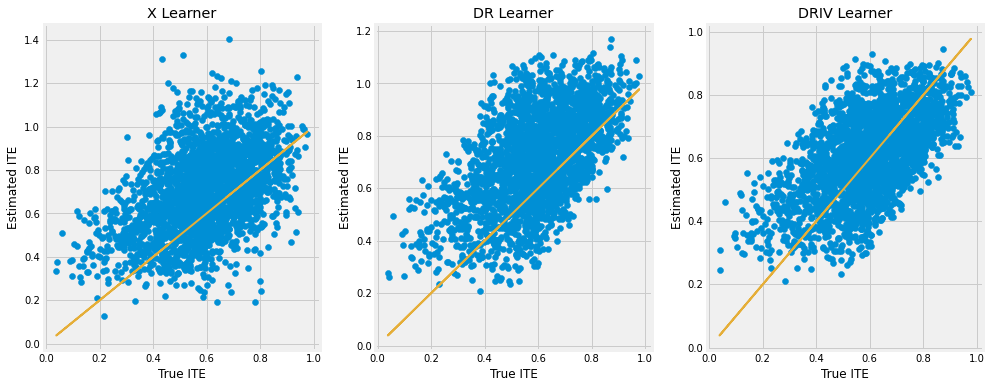

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].scatter(tau[treatment==1], cate_x[treatment==1])
ax[0].plot(tau[treatment==1], tau[treatment==1], color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau[treatment==1], cate_dr[treatment==1])
ax[1].plot(tau[treatment==1], tau[treatment==1], color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')
ax[2].scatter(tau[treatment==1], cate_driv[treatment==1])
ax[2].plot(tau[treatment==1], tau[treatment==1], color='C2', linewidth=2)
ax[2].set_xlabel('True ITE')
ax[2].set_ylabel('Estimated ITE')
ax[2].set_title('DRIV Learner')